In [1]:
from sklearn import metrics
!pip install scipy numpy matplotlib pandas sklearn > /dev/null

In [2]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, learning_curve, permutation_test_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import json

<h2>Dataset configuration</h2>

In [3]:
class Config(object):
    def __init__(self, dataSourceUrl, test_size, n_splits, should_describe_data):
        self.dataSourceUrl = dataSourceUrl
        self.test_size = test_size
        self.n_splits = n_splits
        self.should_describe_data = should_describe_data

def as_config(dict, dataSetName):
    return Config(
        dict[dataSetName]['dataSourceUrl'],
        dict[dataSetName]['test_size'],
        dict[dataSetName]['n_splits'],
        dict[dataSetName]['should_describe_data'],
    )

In [4]:
json_config = """
{
    "iris":{
        "dataSourceUrl": "./data/iris.csv",
        "test_size": 0.2,
        "n_splits": 10,
        "should_describe_data": true
    },
    "wine-quality":{
        "dataSourceUrl": "./data/winequality-white.csv",
        "test_size": 0.2,
        "n_splits": 10,
        "should_describe_data": true
    },
    "glass": {
        "dataSourceUrl": "./data/glass/glass.csv",
        "test_size": 0.2,
        "n_splits": 10,
        "should_describe_data": true
    },
    "cancer": {
        "dataSourceUrl": "./data/cancer.csv",
        "test_size": 0.2,
        "n_splits": 10,
        "should_describe_data": true
    },
    "titanic": {
        "dataSourceUrl": "./data/titanic.csv",
        "test_size": 0.2,
        "n_splits": 10,
        "should_describe_data": true
    }
}"""
cfg = json.loads(json_config)

<h2>Load (and describe) dataset, create test and train datasets</h2>

In [5]:
cfg = as_config(cfg, 'titanic')
dataset = read_csv(cfg.dataSourceUrl, header=0)

if cfg.should_describe_data:    
    print(dataset.shape)
    print(dataset.groupby(dataset.columns[-1]).size())

array = dataset.values
x = array[:,0:len(dataset.columns)-1]
y = array[:,len(dataset.columns)-1]
#na podstawie x i y otrzymujemy tablice testowe i wynikowe
x_train, x_validation, y_train, y_validation = train_test_split(x,y, test_size=cfg.test_size, random_state=1)
    

(1309, 8)
survived
0    967
1    342
dtype: int64


<h2>Classification models</h2>

In [6]:
models = []
models.extend([
    ('KNN', KNeighborsClassifier(), 0),
    ('CART', DecisionTreeClassifier(), 1),
    ('NB', GaussianNB(), 2),
    ('SVM', SVC(gamma='auto'), 3),
    ('MLP', MLPClassifier(alpha=1e-5, hidden_layer_sizes=(50,10), max_iter=5000), 4)
    ])

<h2>Classification</h2>
kfold - k cross-validation to algorytm polegający na testowaniu nauczania(sprawdzania jego wydajności). 
Zbiór TESTOWY jest dzielony na K podzbiorów. W każdej z k iteracji,
brane jest k-1 pozdbiorów, następuje ich nauczanie, następnie sprawdzenie 'jakości' nauczonego modelu.
Przy pomocy danego algorytmu uczenia maszynowego!

In [7]:
def plot_show():
    pyplot.draw()
    pyplot.pause(0.1)

def get_specificity(y_validate, y_predicted):
    cnf_matrix = confusion_matrix(y_validate, y_predicted)
    
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    
    FP = FP.astype(float)
    TN = TN.astype(float)
        
    return np.mean(TN/(TN+FP))
    
def get_learning_curve(classification_model, training_set_enlarging_step=10):
    train_sizes = np.linspace(0.1, 1, training_set_enlarging_step)
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator = classification_model,
        X = x,
        y = y, 
        train_sizes = train_sizes,
        cv = 5,
        scoring = 'accuracy')
    return train_sizes, train_scores, validation_scores

def plot_learning_curve(model,name):
    train_sizes, train_scores, test_scores = \
        get_learning_curve(model)

    plt.style.use('seaborn')
    plt.plot(train_sizes, -train_scores.mean(axis = 1), color= 'red', label = 'Training error')
    plt.plot(train_sizes, -test_scores.mean(axis = 1), color= 'navy',label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for a %s' % name, fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()
    
def compare_algorithms(results, names):
    fig = pyplot.figure()
    fig.suptitle("Algorithm Comparison")
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Algorithm Comparison")
    ax.boxplot(results, labels=names)
    plot_show()

def print_scores(cv_results, predictions):
    print('\nMean %f' % cv_results.mean())
    print('STD %f' % cv_results.std())
    print('\nConfusion matrix:')
    print(confusion_matrix(y_validation, predictions))
    print('\nAccuracy %f' % accuracy_score(y_validation, predictions))
    print('Precision %f' % precision_score(y_validation, predictions, average = 'weighted'))
    print('Recall %f' % recall_score(y_validation, predictions, average = 'weighted'))
    print('Specificity %f' % get_specificity(y_validation, predictions))
    print('\nClassification report:')
    print(classification_report(y_validation, predictions))

def plot_roc_curves():
    fig = pyplot.figure()
    ax = plt.gca()
    for name, model, subplot_row in models:
        rfc_disp = plot_roc_curve(model, x_validation, 
                                  y_validation, ax=ax, alpha=0.8)
    plt.show()

def accuracySignificancy(model, x_train, y_train, cv):
    fig = pyplot.figure()
    fig.suptitle("Estimating accuracy score's statistical significancy")
    ax = fig.add_subplot(1,1,1)
    n_classes = np.unique(y_train).size
    score, permutation_scores, pvalue = permutation_test_score(model, x_train, y_train, scoring="accuracy", cv=cv, n_permutations=100)
    print("Classification score %s (pvalue : %s)" % (score, pvalue))
    # View histogram of permutation scores
    ax.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    ax.plot(2 * [score], ylim, '--g', linewidth=3,
             label='Classification Score'
             ' (pvalue %s)' % pvalue)
    ax.plot(2 * [1. / n_classes], plt.ylim(), '--k', linewidth=3, label='Luck')
    ax.set_xlabel('Score')
    plt.show()

def clustering_scores(x, labels_true=None):
    inertias = []
    silhouette_values = []
    calinski_harabasz = []
    davies_bouldin = []
    k_range = 15
    for k in range(2, k_range):
        model = KMeans(n_clusters=k, random_state=1)
        clustering = model.fit(x)
        labels=clustering.labels_
        inertias.append(clustering.inertia_)
        silhouette_values.append(silhouette_score(x, labels))
        calinski_harabasz.append(calinski_harabasz_score(x, labels))
        davies_bouldin.append(davies_bouldin_score(x, labels))

    fig, ax = plt.subplots(4, 1, figsize=(8,32))
    ax[0].plot(inertias)
    ax[0].set_title("Elbow chart")
    ax[0].set_xlabel('clusters')
    ax[0].set_ylabel('distortion')
    ax[1].plot(silhouette_values)
    ax[1].set_title("Silhouette score")
    ax[1].set_xlabel('clusters')
    ax[1].set_ylabel('Silhouette score')
    ax[2].plot(calinski_harabasz)
    ax[2].set_title("Calinski Harabasz score")
    ax[2].set_xlabel('clusters')
    ax[2].set_ylabel('Calinski Harabasz score')
    ax[3].plot(davies_bouldin)
    ax[3].set_title("Davies Bouldin score")
    ax[3].set_xlabel('clusters')
    ax[3].set_ylabel('Davies Bouldin score')
    plt.tight_layout()
    plt.show()

def evaluate_per_dataset():
    results = []
    names = []
    
    for name, model, subplot_row in models:
            print(f"---------------------------\nRunning classification for: {name}")
            kfold = StratifiedKFold(n_splits=cfg.n_splits, random_state=1, shuffle=True)
            cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
            accuracySignificancy(model, x_train, y_train, kfold)
            results.append(cv_results)
            names.append(name)

            # Make predictions on validation dataset
            model.fit(x_train, y_train)
            predictions = model.predict(x_validation)
            
            print_scores(cv_results, predictions)
            plot_learning_curve(model,name)
    #ROC
    plot_roc_curves()

    # Compare Algorithms - ROC etc
    compare_algorithms(results, names)
    
    clustering_scores(x)

---------------------------
Running classification for: KNN
Classification score 0.7278021978021978 (pvalue : 0.009900990099009901)


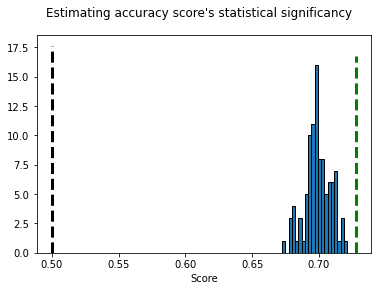


Mean 0.727802
STD 0.027698

Confusion matrix:
[[168  14]
 [ 62  18]]

Accuracy 0.709924
Precision 0.679157
Recall 0.709924
Specificity 0.574038

Classification report:
              precision    recall  f1-score   support

         0.0       0.73      0.92      0.82       182
         1.0       0.56      0.23      0.32        80

    accuracy                           0.71       262
   macro avg       0.65      0.57      0.57       262
weighted avg       0.68      0.71      0.66       262



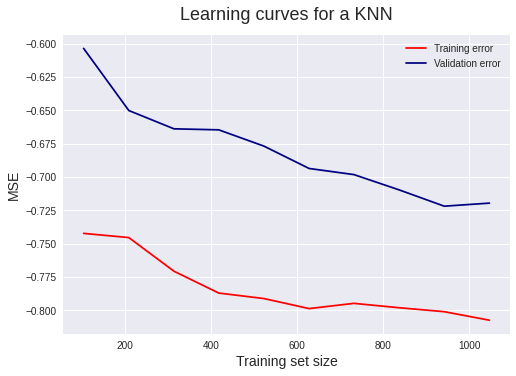

---------------------------
Running classification for: CART
Classification score 0.7564835164835164 (pvalue : 0.009900990099009901)


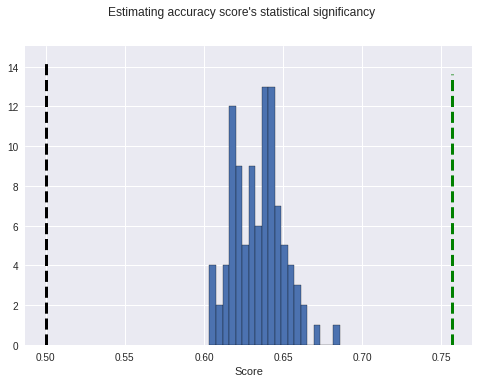


Mean 0.758397
STD 0.055908

Confusion matrix:
[[150  32]
 [ 53  27]]

Accuracy 0.675573
Precision 0.653026
Recall 0.675573
Specificity 0.580838

Classification report:
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78       182
         1.0       0.46      0.34      0.39        80

    accuracy                           0.68       262
   macro avg       0.60      0.58      0.58       262
weighted avg       0.65      0.68      0.66       262



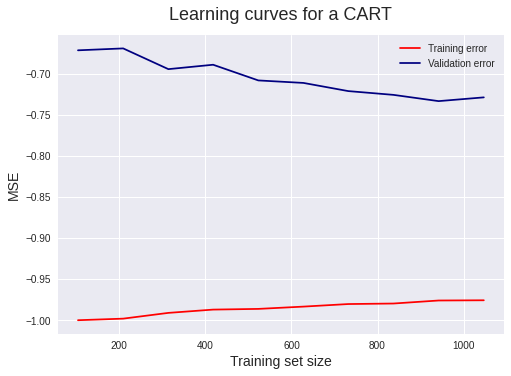

---------------------------
Running classification for: NB
Classification score 0.767948717948718 (pvalue : 0.009900990099009901)


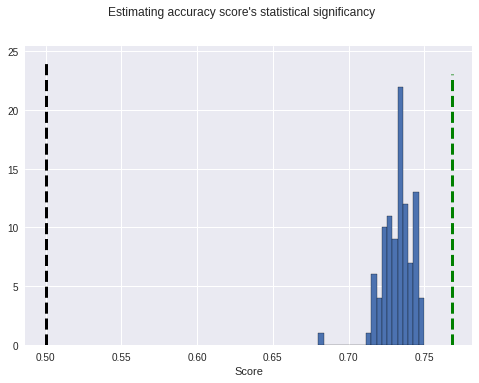


Mean 0.767949
STD 0.036942

Confusion matrix:
[[154  28]
 [ 48  32]]

Accuracy 0.709924
Precision 0.692439
Recall 0.709924
Specificity 0.623077

Classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       182
         1.0       0.53      0.40      0.46        80

    accuracy                           0.71       262
   macro avg       0.65      0.62      0.63       262
weighted avg       0.69      0.71      0.70       262



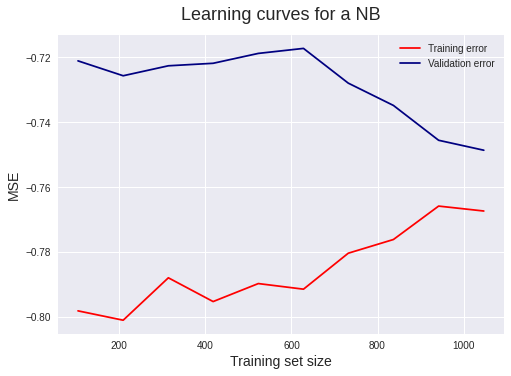

---------------------------
Running classification for: SVM
Classification score 0.7420970695970696 (pvalue : 0.3069306930693069)


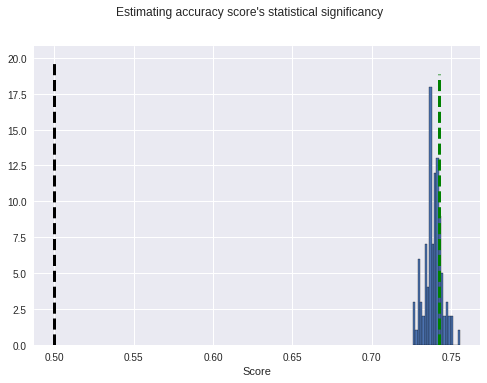


Mean 0.742097
STD 0.021213

Confusion matrix:
[[174   8]
 [ 73   7]]

Accuracy 0.690840
Precision 0.631847
Recall 0.690840
Specificity 0.521772

Classification report:
              precision    recall  f1-score   support

         0.0       0.70      0.96      0.81       182
         1.0       0.47      0.09      0.15        80

    accuracy                           0.69       262
   macro avg       0.59      0.52      0.48       262
weighted avg       0.63      0.69      0.61       262



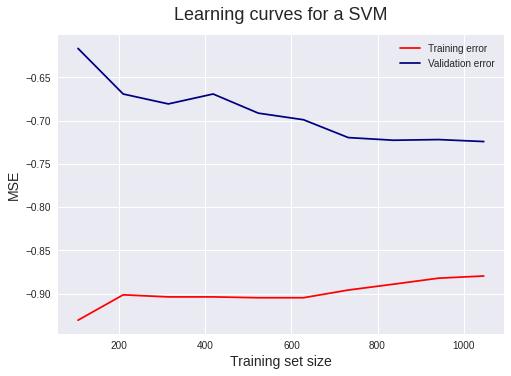

---------------------------
Running classification for: MLP
Classification score 0.7909065934065935 (pvalue : 0.009900990099009901)


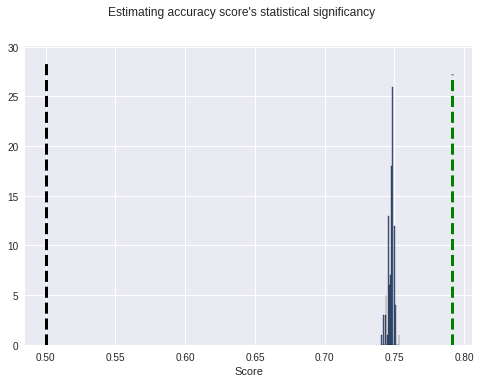


Mean 0.789918
STD 0.031163

Confusion matrix:
[[167  15]
 [ 56  24]]

Accuracy 0.729008
Precision 0.708117
Recall 0.729008
Specificity 0.608791

Classification report:
              precision    recall  f1-score   support

         0.0       0.75      0.92      0.82       182
         1.0       0.62      0.30      0.40        80

    accuracy                           0.73       262
   macro avg       0.68      0.61      0.61       262
weighted avg       0.71      0.73      0.70       262



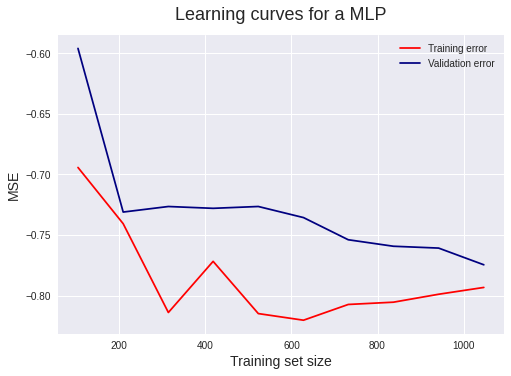

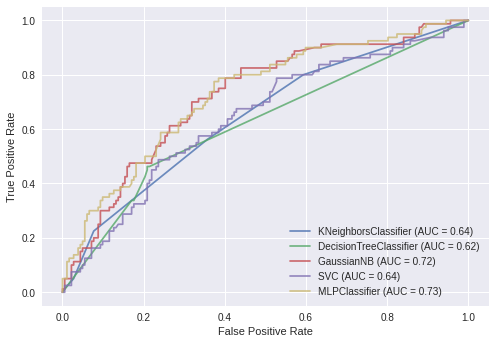

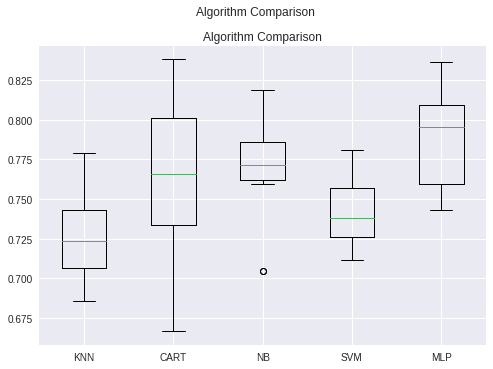

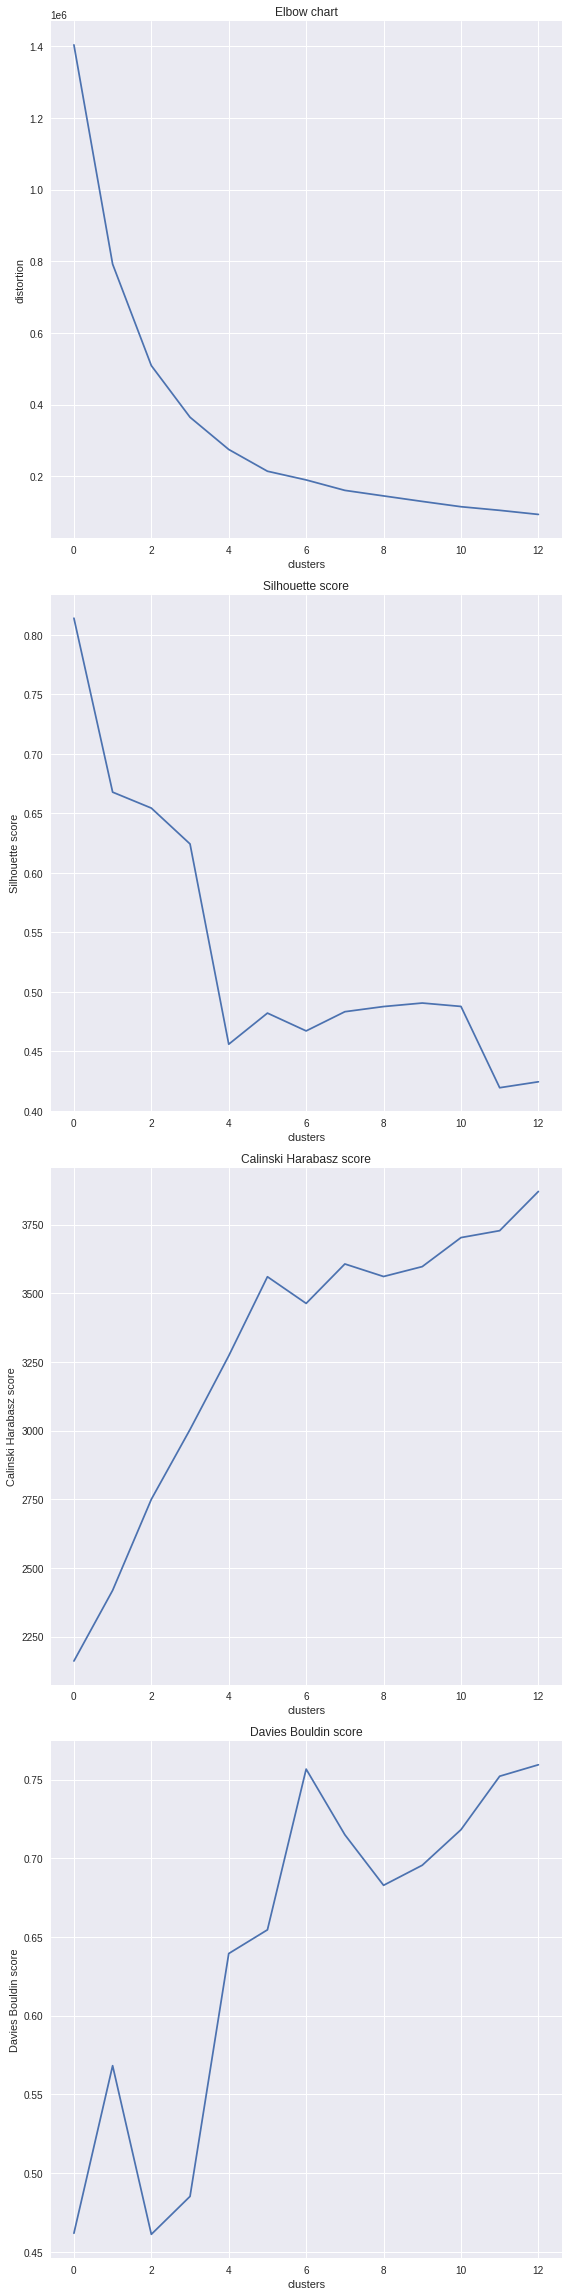

In [8]:
evaluate_per_dataset()